<!--NOTEBOOK_HEADER-->
*This notebook contains material from [Controlling Natural Watersheds](https://jckantor.github.io/Controlling-Natural-Watersheds);
content is available [on Github](https://github.com/jckantor/Controlling-Natural-Watersheds.git).*

<!--NAVIGATION-->
< [Lumped Parameter Model for Lake Dynamics](http://nbviewer.jupyter.org/github/jckantor/Controlling-Natural-Watersheds/blob/master/notebooks/05.01-Lumped_Parameter_Model_for_Lake_Dynamics.ipynb) | [Contents](toc.ipynb) | [Model Predictive Control](http://nbviewer.jupyter.org/github/jckantor/Controlling-Natural-Watersheds/blob/master/notebooks/05.03-Model_Predictive_Control.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/Controlling-Natural-Watersheds/blob/master/notebooks/05.02-Implementation_of_Rainy_Lake_Rule_Curves_with_Feedback_Control.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://raw.githubusercontent.com/jckantor/Controlling-Natural-Watersheds/master/notebooks/05.02-Implementation_of_Rainy_Lake_Rule_Curves_with_Feedback_Control.ipynb"><img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# Implementation of Rainy Lake Rule Curves with Feedback Control

* <a href=#section01>Direct Estimate of Rainy Lake Inflows using the Balance Equation</a>
* <a href=#section02>Constructing a Simulation Data Set for Rainy Lake</a>
* <a href=#section03>Matlab/Simulink Model</a>
* <a href=#section04>Simulation Results</a>

## Initialization

Initilization of the graphics system and computational modules used in this IPython notebook.

In [287]:
# Display graphics inline with the notebook
%matplotlib notebook

# Standard Python modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import os
import datetime

# Modules to display images and data tables
from IPython.display import Image
from IPython.core.display import display

# Data Directory
dir = '../data/'
img = '../images/'

## Direct Estimate of Rainy Lake Inflows using the Balance Equation

A crude estimate of inflows can be found starting with the balance equation

$$A_{RL}\frac{dH_{RL}}{dt} = I_{RL}(t) - O_{RL}(t)$$

where the subscript RL refers to Rainy Lake, and $A$, $H$, $I$, and $O$ refer to area, lake level, inflow, and outflow, respectively. Discretizing in time

$$\frac{A_{RL}}{\Delta t}\left(H_{RL}(k+1)-H_{RL}(k)\right) = I_{RL}(k) - O_{RL}(k)$$

Since the sole output flow from Rainy Lake is through Rainy River, we can solve for inflow

$$I_{RL}(k) = \frac{A_{RL}}{\Delta t}\left(H_{RL}(k+1)-H_{RL}(k)\right) + O_{RL}(k)$$

The estimation method is sensitive to small errors in level measurement and therefore provides an estimate of the inflow plagued by excessive noise.

<IPython.core.display.Javascript object>


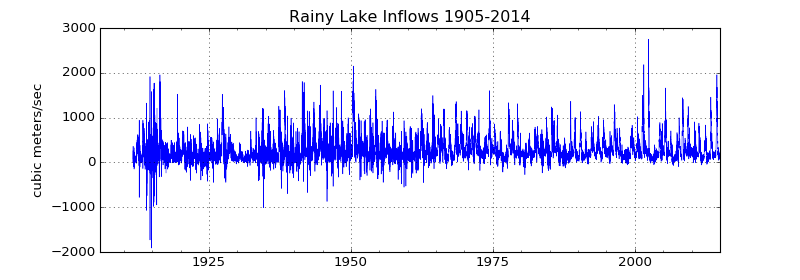

In [288]:
# Load Rainy River Flow and Rainy Lake Level data
RR = pd.read_pickle(dir + 'RR.pkl')
RL = pd.read_pickle(dir + 'RL.pkl')

# Load regression formulae for lake areas
area = pd.read_pickle(dir + 'area.pkl')

# Compute time series for Rainy Lake area in sq. meters
areaRL = pd.Series(area['Rainy Lake'](RL), index = RL.index) * 1.0e6

# Estimate Rainy Lake inflow in cubic meters per second
RLInflow = areaRL*(RL.shift(-1) - RL)/(24*3600) + RR

plt.figure(figsize=(10,3.5))
RLInflow.plot(linewidth=0.5)
plt.title('Rainy Lake Inflows {0}-{1}'.format(
    RLInflow.index.min().strftime('%Y'),
    RLInflow.index.max().strftime('%Y')))
plt.ylabel('cubic meters/sec')
plt.grid()

## Constructing a Simulation Data Set for Rainy Lake

There are evident inconsistencies in the estimated inflows to Rainy Lake prior to 1920. The inconsistenceis extend through to the about 1970. For that reason, only data from 1970 on is retained in a data set to be used for simulating lake levels under alternative control regimes.

<IPython.core.display.Javascript object>


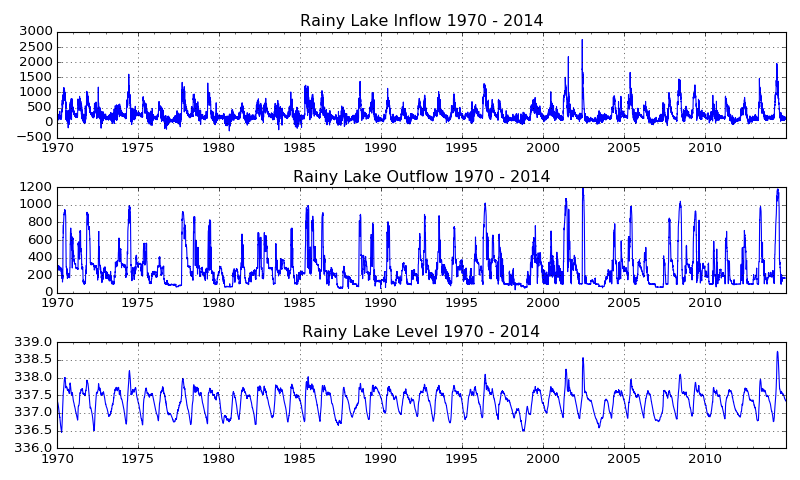

In [289]:
yr = '1970'

RLLevelFlow = pd.concat([RL[yr:],RLinflow[yr:],RR[yr:],],axis=1)
RLLevelFlow.columns = ['Level','Inflow','Outflow']
RLLevelFlow = RLLevelFlow.interpolate()

# Save data to file
RLLevelFlow.to_csv(dir + 'RLLevelFlow.csv')

pstr = RLLevelFlow.index.min().strftime('%Y') + ' - ' + RLLevelFlow.index.max().strftime('%Y')

# Plot raw data from 1970 forward
plt.figure(figsize=(10,6))
plt.subplot(3,1,1)
RLLevelFlow['Inflow'].plot()
plt.title('Rainy Lake Inflow ' + pstr)
plt.grid()

plt.subplot(3,1,2)
RLLevelFlow['Outflow'].plot()
plt.title('Rainy Lake Outflow ' + pstr)
plt.grid()

plt.subplot(3,1,3)
RLLevelFlow['Level'].plot()
plt.title('Rainy Lake Level ' + pstr)
plt.grid()

plt.tight_layout()

<IPython.core.display.Javascript object>


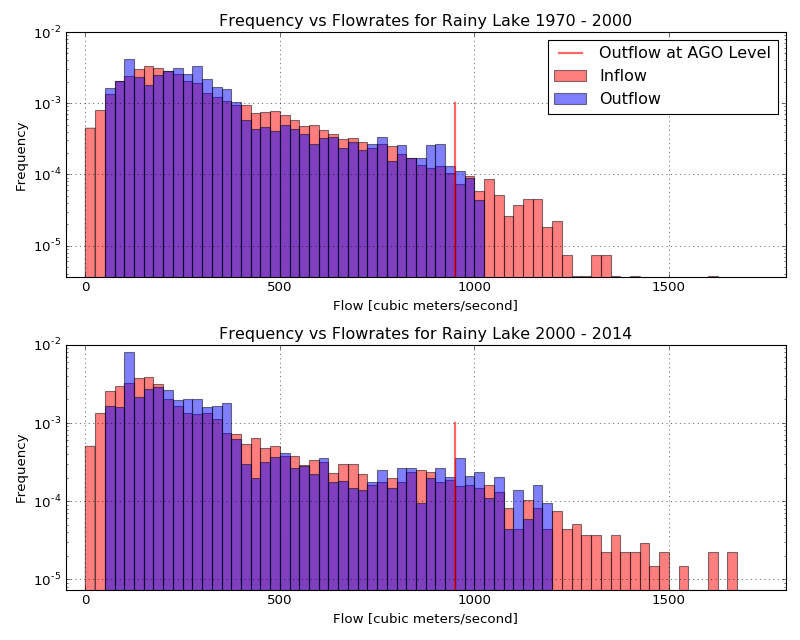

In [283]:
# Plot flow histograms and save image
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(2,1,1)

plt.hold(True)
RLLevelFlow.ix['1970':'1999','Inflow'].hist(bins=range(0, 3000 + 25, 25), \
                       color = 'red', alpha = 0.5, log=True, normed=1)
RLLevelFlow.ix['1970':'1999','Outflow'].hist(bins=range(0, 3000 + 25, 25), \
                 color = 'blue', alpha = 0.5, log=True, normed=1)
plt.plot([950.0,950.0],[0,0.001],'r',lw=2,alpha=0.6)
plt.hold(False)
plt.xlim(-50,1800)
plt.ylim(0,0.01)

plt.xlabel('Flow [cubic meters/second]')
plt.ylabel('Frequency')
plt.legend(['Outflow at AGO Level', 'Inflow','Outflow'])
plt.title('Frequency vs Flowrates for Rainy Lake 1970 - 2000')

plt.subplot(2,1,2)
plt.hold(True)
RLLevelFlow.ix['2000':,'Inflow'].hist(bins=range(0, 3000 + 25, 25), \
                       color = 'red', alpha = 0.5, log=True, normed=1)
RLLevelFlow.ix['2000':,'Outflow'].hist(bins=range(0, 3000 + 25, 25), \
                 color = 'blue', alpha = 0.5, log=True, normed=1)
plt.plot([950.0,950.0],[0,0.001],'r',lw=2,alpha=0.6)
plt.hold(False)
plt.xlim(-50,1800)
plt.ylim(0,0.01)

plt.xlabel('Flow [cubic meters/second]')
plt.ylabel('Frequency')
plt.title('Frequency vs Flowrates for Rainy Lake 2000 - 2014')
plt.tight_layout()

fname = img + 'RLFlowFreq.png'
plt.savefig(fname)
!convert $fname -trim $fname

<IPython.core.display.Javascript object>


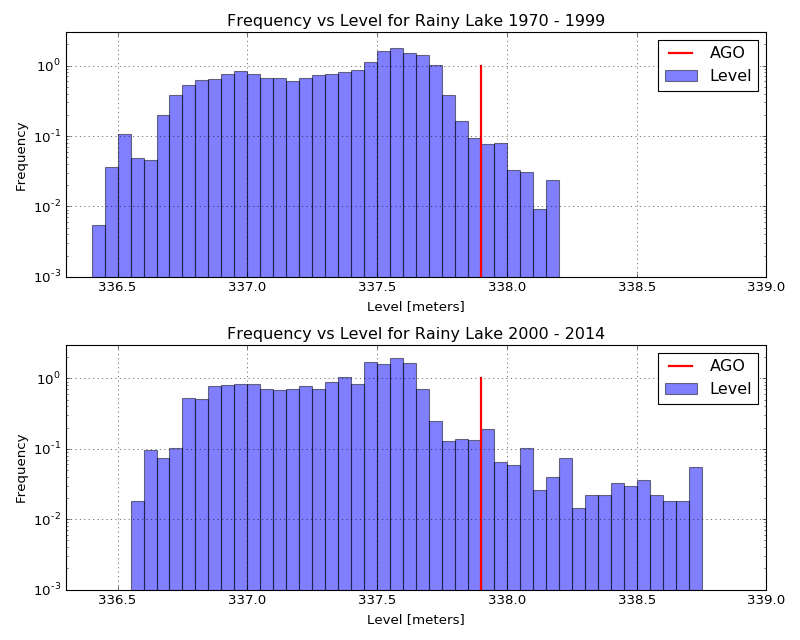

In [290]:
# Plot level histograms and save image

fig = plt.figure(figsize=(10,8))
plt.subplot(2,1,1)

plt.hold(True)
RLLevelFlow.ix['1970':'1999','Level'].hist(bins=np.arange(336.3,339.0,0.05), \
                       color = 'blue', alpha = 0.5, log=True, normed=1)
plt.plot([337.9,337.9],[0.001,1.0],'r',lw=2)
plt.hold(False)
plt.xlim(336.3,339.0)
plt.ylim(0.001,3)

plt.legend(['AGO','Level'])
plt.xlabel('Level [meters]')
plt.ylabel('Frequency')
plt.title('Frequency vs Level for Rainy Lake 1970 - 1999')


plt.subplot(2,1,2)

plt.hold(True)
RLLevelFlow.ix['2000':,'Level'].hist(bins=np.arange(336.3,339.0,0.05), \
                       color = 'blue', alpha = 0.5, log=True, normed=1)
plt.plot([337.9,337.9],[0.001,1.0],'r',lw=2)
plt.hold(False)
plt.xlim(336.3,339.0)
plt.ylim(0.001,3)

plt.legend(['AGO','Level'])
plt.xlabel('Level [meters]')
plt.ylabel('Frequency')
plt.title('Frequency vs Level for Rainy Lake 2000 - 2014')

plt.tight_layout()

fname = img + 'RLFreqStage.png'
plt.savefig(fname)
!convert $fname -trim $fname

Plotting the estimated inflow for a typical year demonstrates the noisy characteristics of this estimate.

<IPython.core.display.Javascript object>


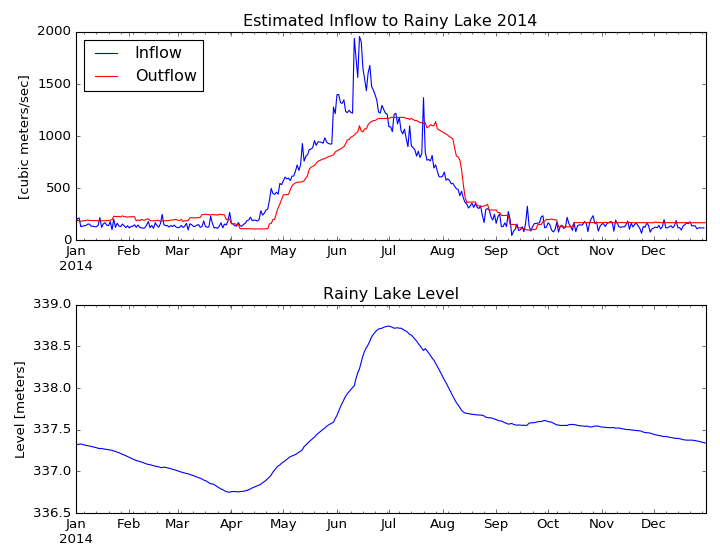

In [265]:
yr = '2014'

plt.figure(figsize=(9,7))
plt.subplot(2,1,1)
plt.hold(True)
RLinflow[yr].plot(color='b',linewidth=1)
RR[yr].plot(color='r')
plt.hold(False)

ax = plt.axis()
plt.ylim([0,ax[3]])
plt.ylabel('[cubic meters/sec]')
plt.title('Estimated Inflow to Rainy Lake ' + yr)
plt.legend(['Inflow','Outflow'],loc='upper left')

plt.subplot(2,1,2)
RL[yr].plot()
plt.ylabel('Level [meters]')
plt.title('Rainy Lake Level')
plt.tight_layout()

## Matlab/Simulink Model

![](../images/RLSim_Model.svg)

In [286]:
!/Applications/Inkscape.app/Contents/Resources/bin/inkscape -f ../images/RLSim_Model.svg ../images/RLSim_Model.eps


** (inkscape-bin:14990): WARNING **: Can't open file: ../images/RLSim_Model.svg (doesn't exist)

** (inkscape-bin:14990): WARNING **: Can't open file: ../images/RLSim_Model.eps (doesn't exist)

(inkscape-bin:14990): Gtk-WARNING **: Unable to rename '/Users/jeff/.recently-used.xbel': No such file or directory

(inkscape-bin:14990): Gtk-WARNING **: Attempting to store changes into `/Users/jeff/.local/share/recently-used.xbel', but failed: Failed to create file '/Users/jeff/.local/share/recently-used.xbel.49IVDY': No such file or directory

(inkscape-bin:14990): Gtk-WARNING **: Attempting to set the permissions of `/Users/jeff/.local/share/recently-used.xbel', but failed: No such file or directory


## Simulation Results

![](../images/RLSim_Results.png)

In [266]:
RLSim_Results = pd.read_csv(dir + 'RLSim_results.csv', index_col = [0], parse_dates = [0])
RLSim_Results = RLSim_Results.resample('D',how='mean')

<IPython.core.display.Javascript object>


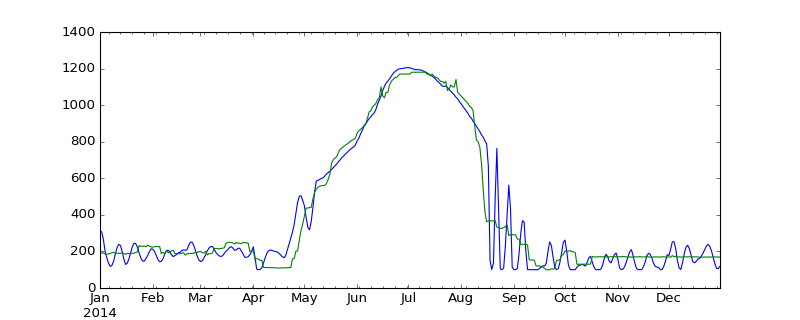

In [267]:
plt.figure(figsize=(10,4))
plt.hold(True)
RLSim_Results.ix['2014':,'outflow_sim'].plot()
RLSim_Results.ix['2014':,'outflow_hist'].plot()
RLSim_Results.ix
plt.hold(False)

<IPython.core.display.Javascript object>


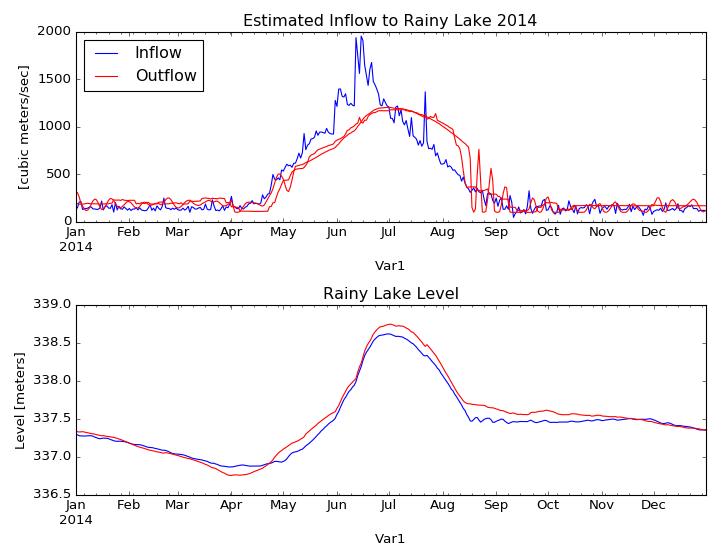

In [269]:
yr = '2014'

plt.figure(figsize=(9,7))
plt.subplot(2,1,1)
plt.hold(True)
RLSim_Results.ix[yr:,'inflow_sim'].plot(color='b',linewidth=1)
RLSim_Results.ix[yr:,'outflow_sim'].plot(color='r',linewidth=1)
RR[yr].plot(color='r')
plt.hold(False)

ax = plt.axis()
plt.ylim([0,ax[3]])
plt.ylabel('[cubic meters/sec]')
plt.title('Estimated Inflow to Rainy Lake ' + yr)
plt.legend(['Inflow','Outflow'],loc='upper left')

plt.subplot(2,1,2)
plt.hold(True)
RLSim_Results.ix[yr:,'level_sim'].plot(color='b',linewidth=1)
RLSim_Results.ix[yr:,'level_hist'].plot(color='r',linewidth=1)
plt.ylabel('Level [meters]')
plt.title('Rainy Lake Level')
plt.tight_layout()

<IPython.core.display.Javascript object>


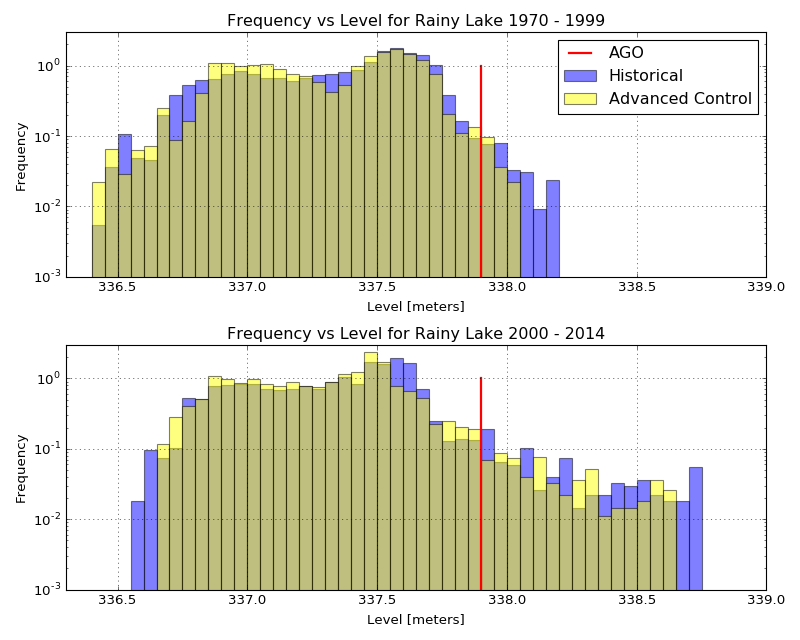

In [292]:
# Plot level histograms and save image

fig = plt.figure(figsize=(10,8))
plt.subplot(2,1,1)

plt.hold(True)
RLLevelFlow.ix['1970':'1999','Level'].hist(bins=np.arange(336.3,339.0,0.05), \
                       color = 'blue', alpha = 0.5, log=True, normed=1)
RLSim_Results.ix['1970':'1999','level_sim'].hist(bins=np.arange(336.3,339.0,0.05), \
                       color = 'yellow', alpha = 0.5, log=True, normed=1)

plt.plot([337.9,337.9],[0.001,1.0],'r',lw=2)
plt.hold(False)
plt.xlim(336.3,339.0)
plt.ylim(0.001,3)

plt.legend(['AGO','Historical','Advanced Control'])
plt.xlabel('Level [meters]')
plt.ylabel('Frequency')
plt.title('Frequency vs Level for Rainy Lake 1970 - 1999')

plt.subplot(2,1,2)

plt.hold(True)
RLLevelFlow.ix['2000':,'Level'].hist(bins=np.arange(336.3,339.0,0.05), \
                       color = 'blue', alpha = 0.5, log=True, normed=1)
RLSim_Results.ix['2000':,'level_sim'].hist(bins=np.arange(336.3,339.0,0.05), \
                       color = 'yellow', alpha = 0.5, log=True, normed=1)

plt.plot([337.9,337.9],[0.001,1.0],'r',lw=2)
plt.hold(False)
plt.xlim(336.3,339.0)
plt.ylim(0.001,3)

plt.xlabel('Level [meters]')
plt.ylabel('Frequency')
plt.title('Frequency vs Level for Rainy Lake 2000 - 2014')

plt.tight_layout()

fname = img + 'RLFreqStage_sim.png'
plt.savefig(fname)
!convert $fname -trim $fname

fname = img + 'RLFreqStage_sim.eps'
plt.savefig(fname, format='eps', dpi=1000)

<IPython.core.display.Javascript object>


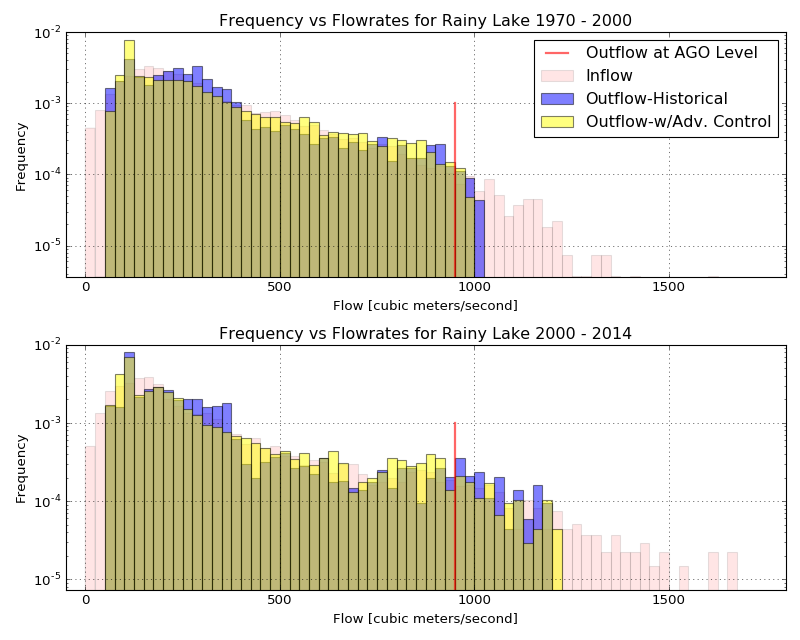

In [293]:
# Plot flow histograms and save image
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(2,1,1)

plt.hold(True)
RLLevelFlow.ix['1970':'1999','Inflow'].hist(bins=range(0, 3000 + 25, 25), \
                       color = 'red', alpha = 0.1, log=True, normed=1)
RLLevelFlow.ix['1970':'1999','Outflow'].hist(bins=range(0, 3000 + 25, 25), \
                 color = 'blue', alpha = 0.5, log=True, normed=1)
RLSim_Results.ix['1970':'1999','outflow_sim'].hist(bins=range(0, 3000 + 25, 25), \
                 color = 'yellow', alpha = 0.5, log=True, normed=1)
plt.plot([950.0,950.0],[0,0.001],'r',lw=2,alpha=0.6)
plt.hold(False)
plt.xlim(-50,1800)
plt.ylim(0,0.01)

plt.xlabel('Flow [cubic meters/second]')
plt.ylabel('Frequency')
plt.legend(['Outflow at AGO Level', 'Inflow','Outflow-Historical','Outflow-w/Adv. Control'])
plt.title('Frequency vs Flowrates for Rainy Lake 1970 - 2000')

plt.subplot(2,1,2)
plt.hold(True)
RLLevelFlow.ix['2000':,'Inflow'].hist(bins=range(0, 3000 + 25, 25), \
                       color = 'red', alpha = 0.1, log=True, normed=1)
RLLevelFlow.ix['2000':,'Outflow'].hist(bins=range(0, 3000 + 25, 25), \
                 color = 'blue', alpha = 0.5, log=True, normed=1)
RLSim_Results.ix['2000':,'outflow_sim'].hist(bins=range(0, 3000 + 25, 25), \
                 color = 'yellow', alpha = 0.5, log=True, normed=1)
plt.plot([950.0,950.0],[0,0.001],'r',lw=2,alpha=0.6)
plt.hold(False)
plt.xlim(-50,1800)
plt.ylim(0,0.01)

plt.xlabel('Flow [cubic meters/second]')
plt.ylabel('Frequency')
plt.title('Frequency vs Flowrates for Rainy Lake 2000 - 2014')
plt.tight_layout()

fname = img + 'RLFlowFreq_sim.png'
plt.savefig(fname)
!convert $fname -trim $fname

fname = img + 'RLFlowFreq_sim.eps'
plt.savefig(fname, format='eps', dpi=1000)

<IPython.core.display.Javascript object>


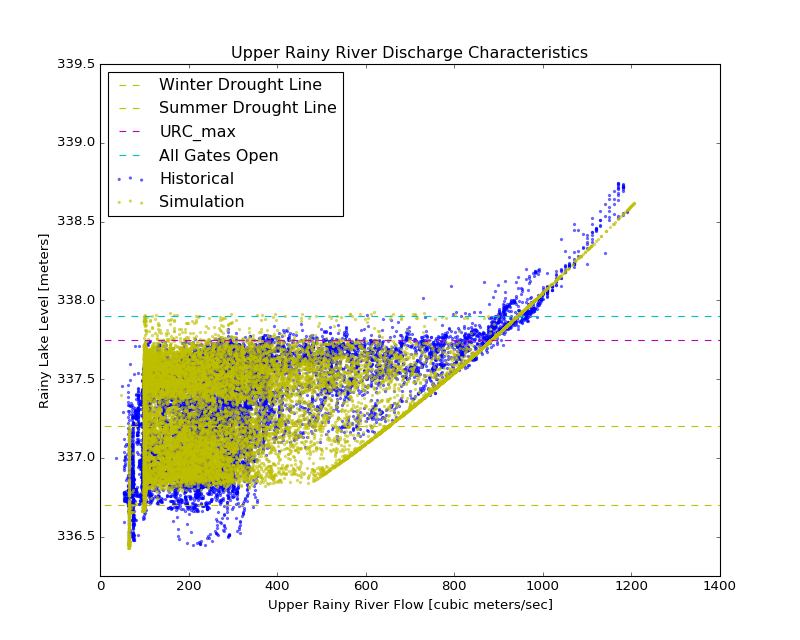

In [272]:
# Get historical flowrates and levels on RR and RL

plt.figure(figsize=(10,8))
plt.hold(True)
plt.scatter(RLSim_Results['outflow_hist'], \
            RLSim_Results['level_hist'],marker='.',color='b',alpha = 0.5,s=15)
plt.scatter(RLSim_Results['outflow_sim'], \
            RLSim_Results['level_sim'],marker='.',color='y',alpha = 0.5,s=15)

ax = plt.axis()
plt.plot([ax[0],ax[1]],[336.70,336.70],'y--')
plt.plot([ax[0],ax[1]],[337.20,337.20],'y--')
plt.plot([ax[0],ax[1]],[337.75,337.75],'m--')
plt.plot([ax[0],ax[1]],[337.90,337.90],'c--')

plt.xlabel('Upper Rainy River Flow [cubic meters/sec]')
plt.ylabel('Rainy Lake Level [meters]')
plt.title('Upper Rainy River Discharge Characteristics')
plt.xlim(0,1400)
plt.ylim(336.25,339.5)
plt.legend(['Winter Drought Line', \
            'Summer Drought Line', \
            'URC_max','All Gates Open', \
            'Historical','Simulation'],loc="upper left")

plt.hold(False)

fname = img + 'RainyRiverDischarge_sim.png'
plt.savefig(fname)
!convert $fname -trim $fname

<IPython.core.display.Javascript object>


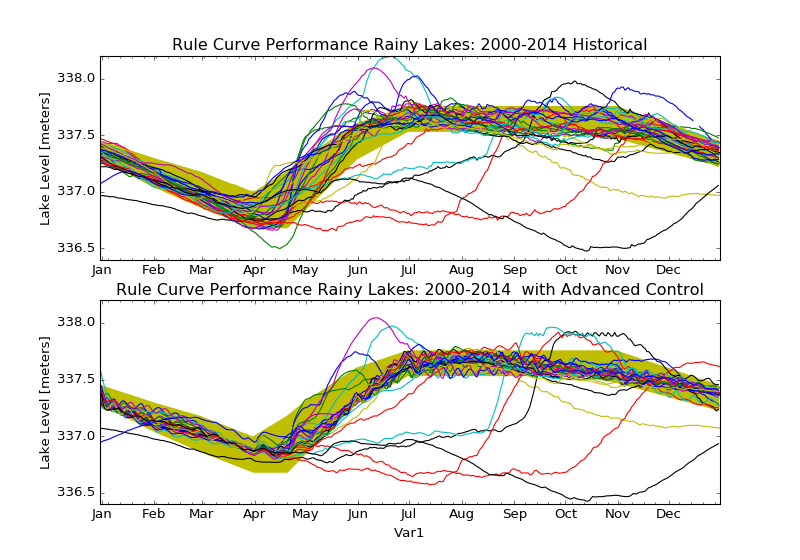

In [297]:
plt.figure(figsize=(10,7))

RL1970 = pd.read_pickle(dir + 'RL1970.pkl')

# Historical

plt.subplot(2,1,1)
plt.hold(True)

RL1970['LRC'].plot(color='y')
RL1970['URC'].plot(color='y')

plt.fill_between(RL1970.index,
                 RL1970['LRC'].tolist(),
                 RL1970['URC'].tolist(),
                 color='y', alpha='1')

plt.ylabel('Lake Level [meters]')
plt.title('Rule Curve Performance Rainy Lakes: 2000-2014 Historical')

e = pd.Series([])

for (yr,r) in RL['1971':'1999'].groupby(RL['1971':'1999'].index.year):
    shift = datetime.datetime(2014,1,1) - datetime.datetime(yr,1,1)
    r = r.tshift(shift.days)
    r.plot()
    e = e.append((r - RL1970['URC']).tshift(-shift.days))

plt.hold(False)

import matplotlib.dates as mdates

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# Simulation

plt.subplot(2,1,2)
plt.hold(True)

RL1970['LRC'].plot(color='y')
RL1970['URC'].plot(color='y')

plt.fill_between(RL1970.index,
                 RL1970['LRC'].tolist(),
                 RL1970['URC'].tolist(),
                 color='y', alpha='1')

plt.ylabel('Lake Level [meters]')
plt.title('Rule Curve Performance Rainy Lakes: 2000-2014  with Advanced Control')

e = pd.Series([])

for (yr,r) in RLSim_Results.ix['1971':'1999','level_sim'].groupby(RL['1971':'1999'].index.year):
    shift = datetime.datetime(2014,1,1) - datetime.datetime(yr,1,1)
    r = r.tshift(shift.days)
    r.plot()
    e = e.append((r - RL1970['URC']).tshift(-shift.days))

plt.hold(False)

import matplotlib.dates as mdates

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))

fname = img + 'RuleCurvePerformance1970-1999_sim.png'
plt.savefig(fname)
!convert $fname -trim $fname

fname = img + 'RuleCurvePerformance1970-1999_sim.eps'
plt.savefig(fname, format='eps', dpi=1000)

<IPython.core.display.Javascript object>


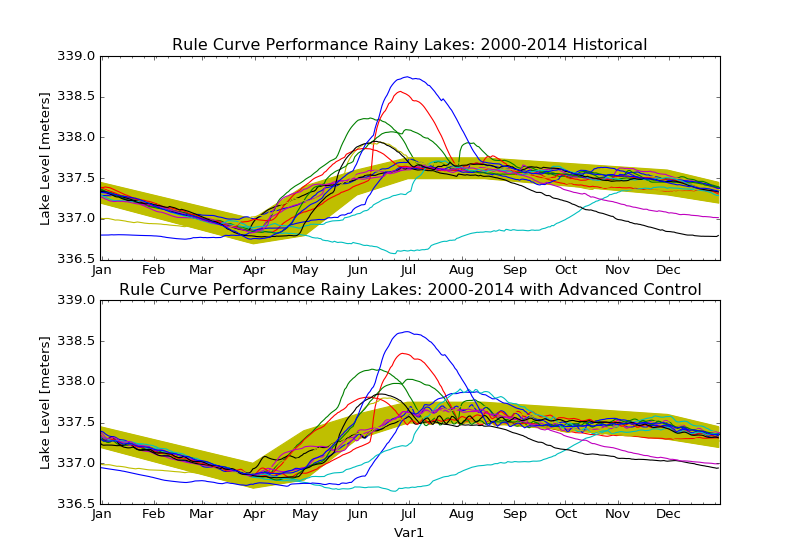

In [298]:
plt.figure(figsize=(10,7))

RL2000 = pd.read_pickle(dir + 'RL2000.pkl')

# Historical

plt.subplot(2,1,1)
plt.hold(True)

RL2000['LRC'].plot(color='y')
RL2000['URC'].plot(color='y')

plt.fill_between(RL2000.index,
                 RL2000['LRC'].tolist(),
                 RL2000['URC'].tolist(),
                 color='y', alpha='1')

plt.ylabel('Lake Level [meters]')
plt.title('Rule Curve Performance Rainy Lakes: 2000-2014 Historical')

e = pd.Series([])

for (yr,r) in RL['2000':'2014'].groupby(RL['2000':'2014'].index.year):
    shift = datetime.datetime(2014,1,1) - datetime.datetime(yr,1,1)
    r = r.tshift(shift.days)
    r.plot()
    e = e.append((r - RL2000['URC']).tshift(-shift.days))

plt.hold(False)

import matplotlib.dates as mdates

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# Simulation

plt.subplot(2,1,2)
plt.hold(True)

RL2000['LRC'].plot(color='y')
RL2000['URC'].plot(color='y')

plt.fill_between(RL2000.index,
                 RL2000['LRC'].tolist(),
                 RL2000['URC'].tolist(),
                 color='y', alpha='1')

plt.ylabel('Lake Level [meters]')
plt.title('Rule Curve Performance Rainy Lakes: 2000-2014 with Advanced Control')

e = pd.Series([])

for (yr,r) in RLSim_Results.ix['2000':'2014','level_sim'].groupby(RL['2000':'2014'].index.year):
    shift = datetime.datetime(2014,1,1) - datetime.datetime(yr,1,1)
    r = r.tshift(shift.days)
    r.plot()
    e = e.append((r - RL2000['URC']).tshift(-shift.days))

plt.hold(False)

import matplotlib.dates as mdates

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))

fname = img + 'RuleCurvePerformance2000-2014_sim.png'
plt.savefig(fname)
!convert $fname -trim $fname

fname = img + 'RuleCurvePerformance2000-2014_sim.eps'
plt.savefig(fname, format='eps', dpi=1000)

In [277]:
idx = (RLSim_Results.index.month >= 5) & (RLSim_Results.index.month <= 9)

e_urc = (RLSim_Results['level_hist'] - RLSim_Results['urc'])[idx]
e_ehl = (RLSim_Results['level_hist'] - RLSim_Results['ehl'])[idx]
e_ago = (RLSim_Results['level_hist'] - RLSim_Results['ago'])[idx]

e_urc_sim = (RLSim_Results['level_sim'] - RLSim_Results['urc'])[idx]
e_ehl_sim = (RLSim_Results['level_sim'] - RLSim_Results['ehl'])[idx]
e_ago_sim = (RLSim_Results['level_sim'] - RLSim_Results['ago'])[idx]

def highEvents(str,S,h):
    print "\n{:s}".format(str),
    print "exceeded {:d} days out of {:d} days.".format(S[S>h].count(),len(S.index))
    print "{:>20s}: {:6.2f}%".format("Frequency", 100.0*float(S[S>h].count())/len(S.index))
    print "{:>20s}: {:7.3f} meters".format("Median Value", (S[S>h]-h).median())
    print "{:>20s}: {:7.3f} meters".format("95th Percentile", (S[S>h]-h).quantile(0.95))
    r = pd.Series([])
    r['Days in Period'] = len(S.index)
    r['Days exceeded'] = S[S>h].count()
    r['Frequency (%)'] = 100.0*float(S[S>h].count())/len(S.index)
    r['Median'] = (S[S>h]-h).median()
    r['95th Percentile'] = (S[S>h]-h).quantile(0.95)
    return r

def highWater(per):
    print "\nPeriod: ", per.index[0].date().strftime("%Y/%b/%d"),\
    "-", per.index[-1].date().strftime("%Y/%b/%d")

print "\n\n\nHistorical Performance of the Rainy Lake Rule Curves"
print "===================================================="

highWater(e_urc['1970':'1999'])
r = highEvents("Rule Curve",e_urc['1970':'1999'],0.0)
r = highEvents("Emergency High Water",e_ehl['1970':'1999'],0.0)
r = highEvents("All Gates Open",e_ago['1970':'1999'],0.0)

highWater(e_urc['2000':])
r = highEvents("Rule Curve",e_urc['2000':],0.0)
r = highEvents("Emergency High Water",e_ehl['2000':],0.0)
r = highEvents("All Gates Open",e_ago['2000':],0.0)

print "\n\n\nPerformance of the Rainy ake Rule Curves with Feedback Control"
print "=============================================================="

highWater(e_urc_sim['1970':'1999'])
r = highEvents("Rule Curve",e_urc_sim['1970':'1999'],0.0)
r = highEvents("Emergency High Water",e_ehl_sim['1970':'1999'],0.0)
r = highEvents("All Gates Open",e_ago_sim['1970':'1999'],0.0)

highWater(e_urc_sim['2000':])
r = highEvents("Rule Curve",e_urc_sim['2000':],0.0)
r = highEvents("Emergency High Water",e_ehl_sim['2000':],0.0)
r = highEvents("All Gates Open",e_ago_sim['2000':],0.0)





Historical Performance of the Rainy Lake Rule Curves

Period:  1970/May/01 - 1999/Sep/30

Rule Curve exceeded 723 days out of 4590 days.
           Frequency:  15.75%
        Median Value:   0.071 meters
     95th Percentile:   0.368 meters

Emergency High Water exceeded 381 days out of 4590 days.
           Frequency:   8.30%
        Median Value:   0.059 meters
     95th Percentile:   0.343 meters

All Gates Open exceeded 109 days out of 4590 days.
           Frequency:   2.37%
        Median Value:   0.097 meters
     95th Percentile:   0.286 meters

Period:  2000/May/01 - 2014/Sep/30

Rule Curve exceeded 413 days out of 2295 days.
           Frequency:  18.00%
        Median Value:   0.249 meters
     95th Percentile:   0.913 meters

Emergency High Water exceeded 335 days out of 2295 days.
           Frequency:  14.60%
        Median Value:   0.212 meters
     95th Percentile:   0.936 meters

All Gates Open exceeded 226 days out of 2295 days.
           Frequency:   9.85%
      

<IPython.core.display.Javascript object>


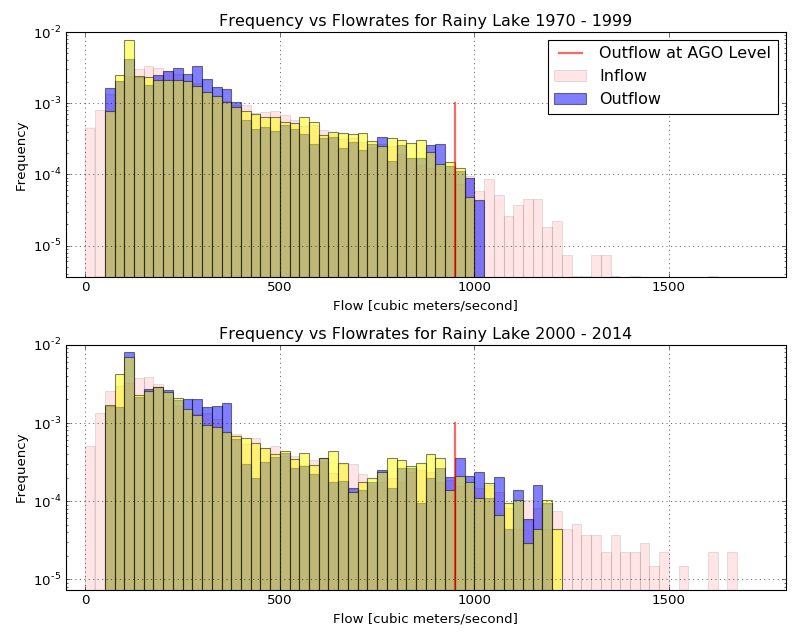

In [276]:
# Plot flow histograms and save image
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(2,1,1)

plt.hold(True)
RLLevelFlow.ix['1970':'1999','Inflow'].hist(bins=range(0, 3000 + 25, 25), \
                       color = 'red', alpha = 0.1, log=True, normed=1)
RLLevelFlow.ix['1970':'1999','Outflow'].hist(bins=range(0, 3000 + 25, 25), \
                 color = 'blue', alpha = 0.5, log=True, normed=1)
RLSim_Results.ix['1970':'1999','outflow_sim'].hist(bins=range(0, 3000 + 25, 25), \
                 color = 'yellow', alpha = 0.5, log=True, normed=1)
plt.plot([950.0,950.0],[0,0.001],'r',lw=2,alpha=0.6)
plt.hold(False)
plt.xlim(-50,1800)
plt.ylim(0,0.01)

plt.xlabel('Flow [cubic meters/second]')
plt.ylabel('Frequency')
plt.legend(['Outflow at AGO Level', 'Inflow','Outflow'])
plt.title('Frequency vs Flowrates for Rainy Lake 1970 - 1999')

plt.subplot(2,1,2)
plt.hold(True)
RLLevelFlow.ix['2000':,'Inflow'].hist(bins=range(0, 3000 + 25, 25), \
                       color = 'red', alpha = 0.1, log=True, normed=1)
RLLevelFlow.ix['2000':,'Outflow'].hist(bins=range(0, 3000 + 25, 25), \
                 color = 'blue', alpha = 0.5, log=True, normed=1)
RLSim_Results.ix['2000':,'outflow_sim'].hist(bins=range(0, 3000 + 25, 25), \
                 color = 'yellow', alpha = 0.5, log=True, normed=1)
plt.plot([950.0,950.0],[0,0.001],'r',lw=2,alpha=0.6)
plt.hold(False)
plt.xlim(-50,1800)
plt.ylim(0,0.01)

plt.xlabel('Flow [cubic meters/second]')
plt.ylabel('Frequency')
plt.title('Frequency vs Flowrates for Rainy Lake 2000 - 2014')
plt.tight_layout()

fname = img + 'RLFlowFreq_sim.png'
plt.savefig(fname)
!convert $fname -trim $fname

<!--NAVIGATION-->
< [Lumped Parameter Model for Lake Dynamics](http://nbviewer.jupyter.org/github/jckantor/Controlling-Natural-Watersheds/blob/master/notebooks/05.01-Lumped_Parameter_Model_for_Lake_Dynamics.ipynb) | [Contents](toc.ipynb) | [Model Predictive Control](http://nbviewer.jupyter.org/github/jckantor/Controlling-Natural-Watersheds/blob/master/notebooks/05.03-Model_Predictive_Control.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/Controlling-Natural-Watersheds/blob/master/notebooks/05.02-Implementation_of_Rainy_Lake_Rule_Curves_with_Feedback_Control.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://raw.githubusercontent.com/jckantor/Controlling-Natural-Watersheds/master/notebooks/05.02-Implementation_of_Rainy_Lake_Rule_Curves_with_Feedback_Control.ipynb"><img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>